<a href="https://colab.research.google.com/github/omiyawaki/miyawaki-2025-nonmonotonic-moist-adiabat/blob/main/Figure_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

--- Starting Main Calculation (Term B Decomposition) ---
Processing Ts = 280.0 K...
Processing Ts = 281.0 K...
Processing Ts = 282.0 K...
Processing Ts = 283.0 K...
Processing Ts = 284.0 K...
Processing Ts = 285.0 K...
Processing Ts = 286.0 K...
Processing Ts = 287.0 K...
Processing Ts = 288.0 K...
Processing Ts = 289.0 K...
Processing Ts = 290.0 K...
Processing Ts = 291.0 K...
Processing Ts = 292.0 K...
Processing Ts = 293.0 K...
Processing Ts = 294.0 K...
Processing Ts = 295.0 K...
Processing Ts = 296.0 K...
Processing Ts = 297.0 K...
Processing Ts = 298.0 K...
Processing Ts = 299.0 K...
Processing Ts = 300.0 K...
Processing Ts = 301.0 K...
Processing Ts = 302.0 K...
Processing Ts = 303.0 K...
Processing Ts = 304.0 K...
Processing Ts = 305.0 K...
Processing Ts = 306.0 K...
Processing Ts = 307.0 K...
Processing Ts = 308.0 K...
Processing Ts = 309.0 K...
Processing Ts = 310.0 K...
Processing Ts = 311.0 K...
Processing Ts = 312.0 K...
Processing Ts = 313.0 K...
Processing Ts = 314.0 K..

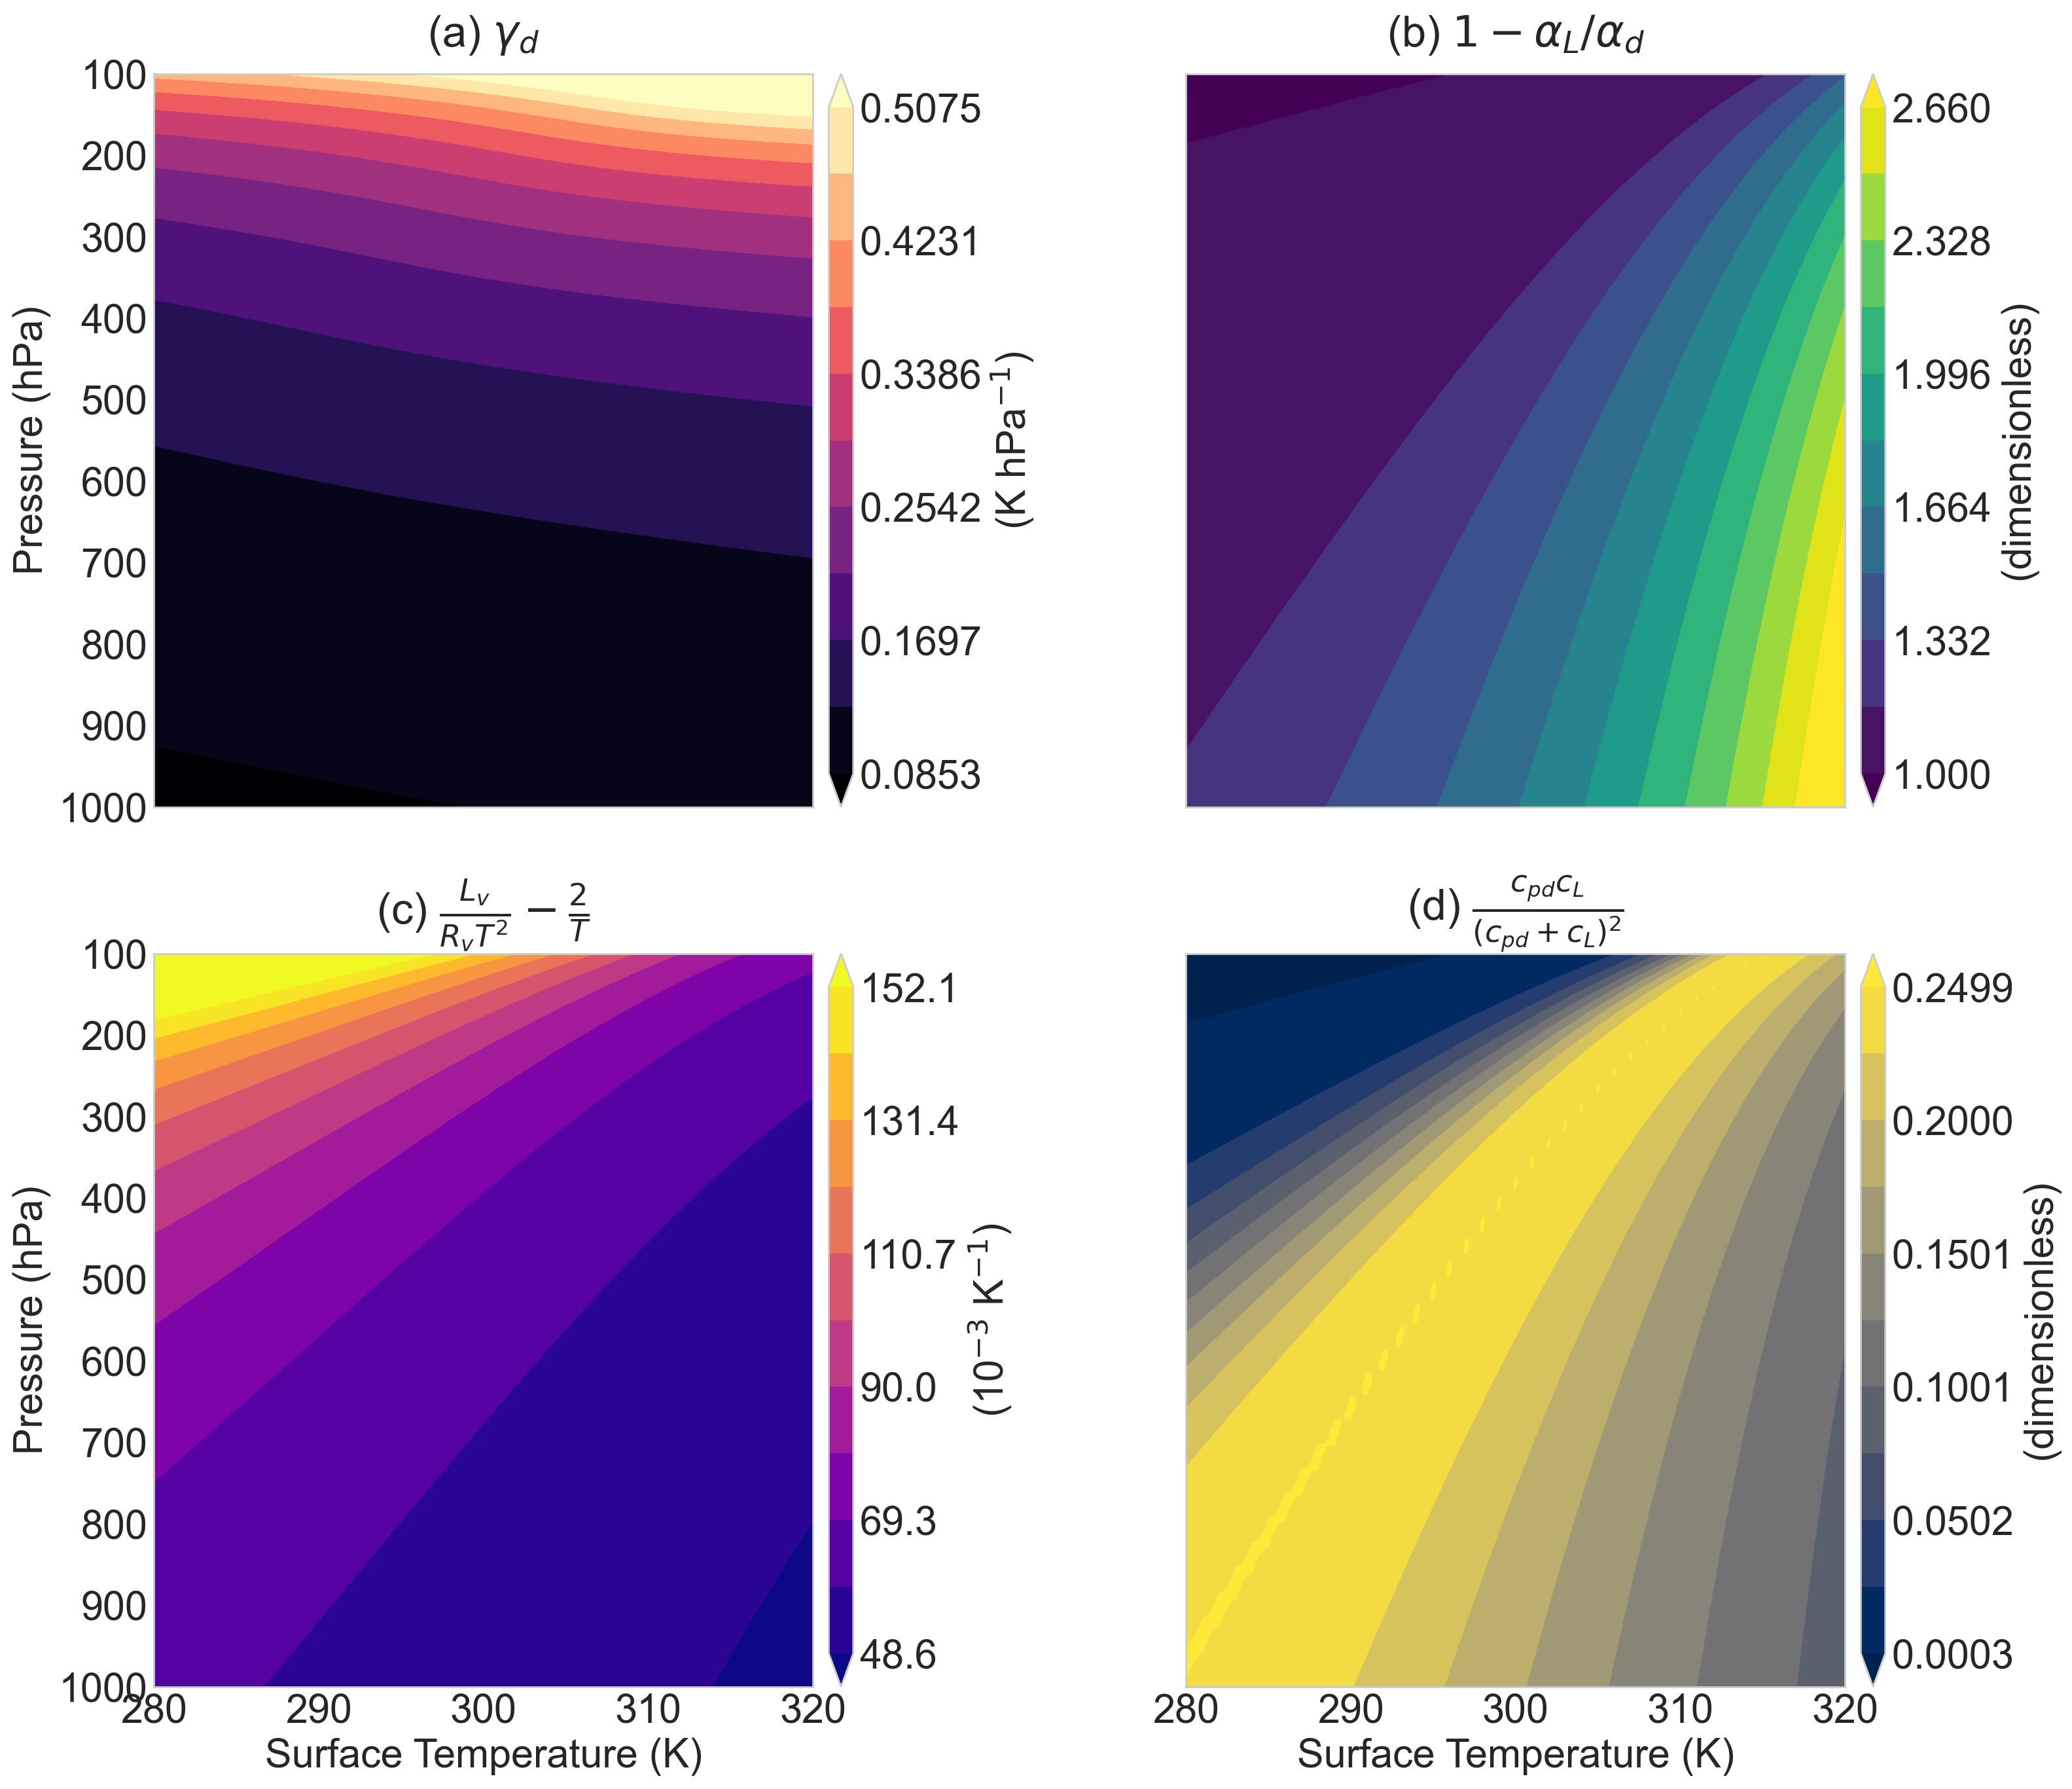

Figure 3 saved as fig-3.png

Script finished.


In [1]:
# ==============================================================================
# SCRIPT TO CALCULATE AND PLOT FIGURE 3 (Decomposition of Term B)
#
# This script visualizes the four components of the analytical expression for
# Term B, the heat capacity contribution to the moist adiabat's sensitivity.
#
# Term B approx -gamma_d * (1 - alpha_L/alpha_d) * (L/RvT^2 - 2/T) * (cpd*cL)/(cpd+cL)^2
#
# The script performs the following actions:
# 1. Defines thermodynamic constants and functions.
# 2. Calculates moist adiabatic profiles for a range of surface temperatures (Ts).
# 3. For each profile, it computes the four terms of the Term B expression at
#    each pressure level.
# 4. It stores these results in 2D grids (Pressure vs. Ts).
# 5. Creates Figure 3, a 2x2 filled contour plot showing each of the four
#    terms, revealing how they combine to produce the non-monotonic shape.
# ==============================================================================

# For sharper inline plots in Jupyter environments
%config InlineBackend.figure_format = 'retina'

import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import root_scalar
from scipy import constants
import time

# --- Physical Constants ---
g = constants.g
cpd = 1005.7
Rd = 287.05
Rv = 461.5
epsilon = Rd / Rv
P0 = 100000.0
Lv = 2.501e6

# --- Thermodynamic Functions ---

def saturation_vapor_pressure(T):
    """Calculates saturation vapor pressure (es) in Pa."""
    T_celsius = T - 273.15
    es_hPa = 6.112 * np.exp((17.67 * T_celsius) / (T_celsius + 243.5))
    return es_hPa * 100.0

def saturation_specific_humidity(p, T):
    """Calculates saturation specific humidity (qs) in kg/kg."""
    es = saturation_vapor_pressure(T)
    es = np.minimum(es, p * 0.99)
    denominator = p - (1.0 - epsilon) * es
    qs = np.divide(epsilon * es, denominator, out=np.full_like(p, 1e-9), where=denominator>0)
    return np.maximum(qs, 1e-9)

def dqs_dT(p, T, dT=0.01):
    """Numerically calculates d(qs)/dT at constant p."""
    qs_plus = saturation_specific_humidity(p, T + dT)
    qs_minus = saturation_specific_humidity(p, T - dT)
    return (qs_plus - qs_minus) / (2 * dT)

def dqs_dp(p, T, dp=10.0):
    """Numerically calculates d(qs)/dp at constant T."""
    qs_plus = saturation_specific_humidity(p + dp, T)
    qs_minus = saturation_specific_humidity(p - dp, T)
    return (qs_plus - qs_minus) / (2 * dp)

def virtual_temperature(T, p):
    """Calculates virtual temperature (Tv) assuming saturation."""
    qs = saturation_specific_humidity(p, T)
    Tv = T * (1.0 + (1.0 / epsilon - 1.0) * qs)
    return np.maximum(Tv, 10.0)

def calculate_mse(T, p, z):
    """Calculates Moist Static Energy (MSE) in J/kg."""
    qs = saturation_specific_humidity(p, T)
    mse = cpd * T + g * z + Lv * qs
    return mse

def calculate_profile_with_rootfinder(T_surf, p_surf, p_grid):
    """Calculates T(p) by conserving MSE at each pressure step."""
    n_steps = len(p_grid)
    T_profile = np.full(n_steps, np.nan)
    z_profile = np.full(n_steps, np.nan)
    T_profile[0], z_profile[0] = T_surf, 0.0
    mse_conserved = calculate_mse(T_profile[0], p_grid[0], 0.0)
    for i in range(n_steps - 1):
        T_curr, p_curr, z_curr = T_profile[i], p_grid[i], z_profile[i]
        p_next = p_grid[i+1]
        if np.isnan(T_curr) or p_curr <= 0: break
        Tv_curr = virtual_temperature(T_curr, p_curr)
        alpha_curr = (Rd * Tv_curr) / p_curr
        dz = - (alpha_curr / g) * (p_next - p_curr)
        z_next = z_curr + dz
        def mse_residual(T_guess): return calculate_mse(T_guess, p_next, z_next) - mse_conserved
        try:
            bracket = [150.0, T_curr + 5.0]
            if mse_residual(bracket[0]) * mse_residual(bracket[1]) > 0: break
            sol = root_scalar(mse_residual, bracket=bracket, method='brentq', xtol=1e-3)
            if sol.converged:
                T_profile[i+1], z_profile[i+1] = sol.root, z_next
            else: break
        except (ValueError, RuntimeError): break
    return T_profile

# --- Main Calculation Block ---
print("--- Starting Main Calculation (Term B Decomposition) ---")
start_time = time.time()

# Parameters
T_surf_values = np.arange(280, 320.1, 1.0)
p_surf_pa = 100000.0
p_top_pa = 10000.0
dp_pa = -50.0
p_grid = np.arange(p_surf_pa, p_top_pa + dp_pa, dp_pa)

# Initialize 2D grids for storing results
n_p, n_t = len(p_grid), len(T_surf_values)
term1_grid = np.full((n_p, n_t), np.nan) # gamma_d
term2_grid = np.full((n_p, n_t), np.nan) # 1 - alpha_L/alpha_d
term3_grid = np.full((n_p, n_t), np.nan) # (L/RvT^2 - 2/T)
term4_grid = np.full((n_p, n_t), np.nan) # cpd*cL / (cpd+cL)^2

for i, T_s in enumerate(T_surf_values):
    print(f"Processing Ts = {T_s:.1f} K...")
    T_profile = calculate_profile_with_rootfinder(T_s, p_surf_pa, p_grid)
    
    if not np.isnan(T_profile[-1]):
        # Calculate thermodynamic quantities along the profile
        alpha_d = Rd * T_profile / p_grid
        c_L = Lv * dqs_dT(p_grid, T_profile)
        alpha_L = Lv * dqs_dp(p_grid, T_profile)
        
        # Term 1: Dry adiabat, gamma_d
        term1_grid[:, i] = alpha_d / cpd
        
        # Term 2: Volume ratio term
        term2_grid[:, i] = 1 - (alpha_L / alpha_d)
        
        # Term 3: Temperature-dependent term from d(c_L)/dT
        term3_grid[:, i] = (Lv / (Rv * T_profile**2)) - (2 / T_profile)
        
        # Term 4: The share-product kernel
        term4_grid[:, i] = (cpd * c_L) / (cpd + c_L)**2
    else:
        print(f" -> Failed to generate complete profile for Ts = {T_s:.1f} K.")

print(f"\n--- Calculation Finished in {time.time() - start_time:.2f} seconds ---\n")

# --- Plotting Figure 3 ---
print("--- Generating Figure 3 ---")
plt.style.use('seaborn-v0_8-whitegrid')
base_fontsize = 22
plt.rcParams.update({
    'font.size': base_fontsize, 'axes.titlesize': base_fontsize + 2,
    'axes.labelsize': base_fontsize, 'xtick.labelsize': base_fontsize,
    'ytick.labelsize': base_fontsize
})

fig, axes = plt.subplots(2, 2, figsize=(18, 16), sharex=True, sharey=True)
p_hpa_grid = p_grid / 100.0
T_grid_K, P_grid_hPa = np.meshgrid(T_surf_values, p_hpa_grid)

# Define plotting data and settings
plot_data = [
    {'ax': axes[0, 0], 'grid': term1_grid * 100, 'title': r'(a) $\gamma_d$', 'cmap': 'magma', 'label': '(K hPa$^{-1}$)'},
    {'ax': axes[0, 1], 'grid': term2_grid, 'title': r'(b) $1 - \alpha_L/\alpha_d$', 'cmap': 'viridis', 'label': '(dimensionless)'},
    {'ax': axes[1, 0], 'grid': term3_grid * 1e3, 'title': r'(c) $\frac{L_v}{R_v T^2} - \frac{2}{T}$', 'cmap': 'plasma', 'label': '(10$^{-3}$ K$^{-1}$)'},
    {'ax': axes[1, 1], 'grid': term4_grid, 'title': r'(d) $\frac{c_{pd} c_L}{(c_{pd} + c_L)^2}$', 'cmap': 'cividis', 'label': '(dimensionless)'}
]

for data in plot_data:
    ax = data['ax']
    # Use robust quantiles for contour levels to handle outliers
    vmin, vmax = np.nanquantile(data['grid'], 0.02), np.nanquantile(data['grid'], 0.98)
    levels = np.linspace(vmin, vmax, 11)
    
    contour = ax.contourf(T_grid_K, P_grid_hPa, data['grid'], levels=levels, cmap=data['cmap'], extend='both')
    ax.set_title(data['title'], pad=15)
    
    cbar = fig.colorbar(contour, ax=ax, orientation='vertical', pad=0.02, aspect=30)
    cbar.set_label(data['label'])

# Set shared labels and properties
for ax in axes.flat:
    ax.invert_yaxis()
    ax.set_ylim(1000, 100)

axes[1, 0].set_xlabel('Surface Temperature (K)')
axes[1, 1].set_xlabel('Surface Temperature (K)')
axes[0, 0].set_ylabel('Pressure (hPa)')
axes[1, 0].set_ylabel('Pressure (hPa)')

fig.align_ylabels(axes[:, 0])
plt.subplots_adjust(hspace=0.2, wspace=0.3)

fig3_filename = "fig-3.png"
plt.savefig(fig3_filename, dpi=300, bbox_inches='tight')
plt.show()
print(f"Figure 3 saved as {fig3_filename}")

print("\nScript finished.")
